# Spectrum Estimation
by John Swoboda

This notebook will use portions of the SimISR and ISRSpectrum software modules to create IS spectra and show different ways of estimating them. There will also be examples using CWGN from the random number generator in scipy.

## Import Everything

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack as scfft
from SimISR.utilFunctions import makesumrule,MakePulseDataRepLPC,spect2acf,acf2spect,CenteredLagProduct
from SimISR.IonoContainer import IonoContainer,MakeTestIonoclass
from ISRSpectrum.ISRSpectrum import ISRSpectrum
import seaborn as sns

## Set up 
Set the number of points desired for the averaging and length of spectra. Also set up seaborn formats. 

In [23]:
spfreq=50e3
nspec=512
rep1=10000
# setup seaborne
sns.set_style("whitegrid")
sns.set_context("notebook")

## IS Spectra
This will create an example ISR spectra that will be used.

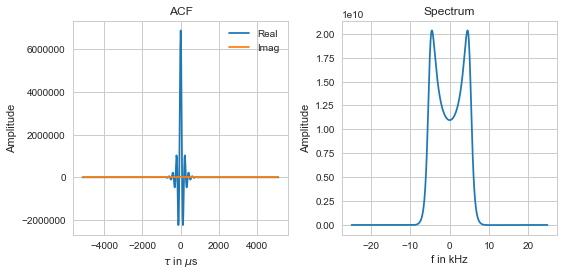

In [35]:
ISpec_ion = ISRSpectrum(centerFrequency = 449e6, nspec=nspec, sampfreq=spfreq,dFlag=False)

species=['O+','e-']
databloc = sp.array([[1.66e10,1e3],[1.66e10,2.5e3]])

f,cur_spec,rcs = ISpec_ion.getspecsep(databloc,species,rcsflag=True)
specsum = sp.absolute(cur_spec).sum()
cur_spec = len(cur_spec)*cur_spec*rcs/specsum
tau,acf=spect2acf(f,cur_spec)

fig,ax = plt.subplots(1,2,sharey=False, figsize=(8,4),facecolor='w')
rp,imp=ax[0].plot(tau*1e6,acf.real,tau*1e6,acf.imag)
ax[0].legend([rp,imp],['Real','Imag'])
ax[0].set_ylabel('Amplitude')
ax[0].set_title('ACF')
ax[0].set_xlabel(r'$\tau$ in $\mu$s')

ax[1].plot(f*1e-3,cur_spec.real)
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Spectrum')
ax[1].set_xlabel(r'f in kHz')
fig.tight_layout()

## White Noise
A periodogram is applied to complex white Gaussian Noise. This is here in order to show that the output of the scipy random number generator outputs uncorrelated random variables. 

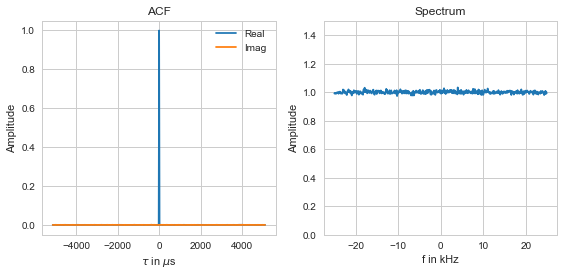

In [36]:
xin =sp.power(2,-.5)*(sp.random.randn(rep1,nspec)+1j*sp.random.randn(rep1,nspec))

Xfft=sp.power(nspec,-.5)*scfft.fftshift(scfft.fft(xin,axis=-1),axes=-1)
Xperiod=sp.power(Xfft.real,2).mean(0) +sp.power(Xfft.imag,2).mean(0)
tau2,acfperiod=spect2acf(f,Xperiod*nspec)

fig2,ax2 = plt.subplots(1,2,sharey=False, figsize=(8,4),facecolor='w')
rp,imp=ax2[0].plot(tau2*1e6,acfperiod.real,tau2*1e6,acfperiod.imag)
ax2[0].legend([rp,imp],['Real','Imag'])
ax2[0].set_ylabel('Amplitude')
ax2[0].set_title('ACF')
ax2[0].set_xlabel(r'$\tau$ in $\mu$s')

ax2[1].plot(f*1e-3,Xperiod.real)
ax2[1].set_ylabel('Amplitude')
ax2[1].set_title('Spectrum')
ax2[1].set_xlabel(r'f in kHz')
ax2[1].set_ylim([0.,1.5])
fig2.tight_layout()

## Shaped Noise
A set of shaped noise is created using the IS spectrum formed earlier. Using linear pridictive coding to apply the spectrum to the noise through the MakePulseDataRepLPC function. This is similar to the method used by vocoders to encode human speech. To show the effect of the LPC coloring a periodogram esitmator is applied to noise the noise.

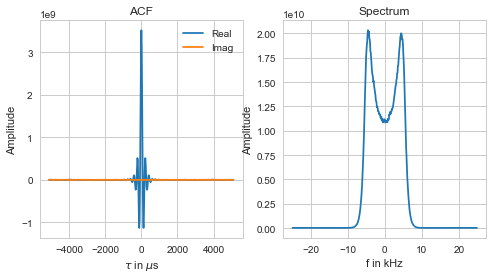

In [37]:
pulse=sp.ones(nspec)
Xdata = MakePulseDataRepLPC(pulse,cur_spec,30,rep1,numtype = sp.complex128)

Xfftd=sp.power(nspec,-.5)*scfft.fftshift(scfft.fft(Xdata,axis=-1),axes=-1)
Xperiodd=sp.power(Xfftd.real,2).mean(0) +sp.power(Xfftd.imag,2).mean(0)
tau3,acfperiodd=spect2acf(f,Xperiodd*nspec)

fig3,ax3 = plt.subplots(1,2,sharey=False, figsize=(8,4),facecolor='w')
rp,imp=ax3[0].plot(tau3*1e6,acfperiodd.real,tau3*1e6,acfperiodd.imag)
ax3[0].legend([rp,imp],['Real','Imag'])
ax3[0].set_ylabel('Amplitude')
ax3[0].set_title('ACF')
ax3[0].set_xlabel(r'$\tau$ in $\mu$s')

ax3[1].plot(f*1e-3,Xperiodd.real)
ax3[1].set_ylabel('Amplitude')
ax3[1].set_title('Spectrum')
ax3[1].set_xlabel(r'f in kHz')
fig2.tight_layout()

## Window Function
When a long pulse is used in ISR the ACF is esitmated instead of the spectrum directly through the periodogram estimator. The estimation is a two step process, first estimate the lags and then do a summation rule. This leads to a windowing of the ACF shown in this. The window is also shown in the frequency domain which will be applied as a convolution to the original spectra in frequency.

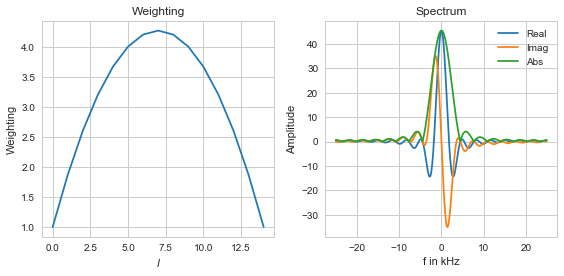

In [38]:
L=15.
v=1
l=sp.arange(L)
W=-l**2/(L*v) + (L-v)*l/L/v+1
Wp=sp.pad(W,(int(sp.ceil(float(nspec-L)/2)),int(sp.floor(float(nspec-L)/2))),'constant',constant_values=0)
wfft=scfft.fftshift(scfft.fft(W,n=nspec))

fig4,ax4 = plt.subplots(1,2,sharey=False, figsize=(8,4),facecolor='w')
ax4[0].plot(l,W)  
ax4[0].set_ylabel('Weighting')
ax4[0].set_title('Weighting')
ax4[0].set_xlabel(r'$l$')
rp,imp,abp=ax4[1].plot(f*1e-3,wfft.real,f*1e-3,wfft.imag,f*1e-3,sp.absolute(wfft))
ax4[1].legend([rp,imp,abp],['Real','Imag','Abs'])
ax4[1].set_ylabel('Amplitude')
ax4[1].set_title('Spectrum')
ax4[1].set_xlabel(r'f in kHz')
fig4.tight_layout()

## Full ISR Data Creation and Estimator
The basics data creation and processing behind SimISR for this case for only one beam. The data is created along a set of samples by adding together a set of uncorrelated data sets together. These sets of pulses that are added together are uncorrelated because any spatial correlation of the electron density fluctuations are much smaller than a range gate. After that the ACFs are estimated they are plotted with the input ACF and spectra with the window applied.

In [39]:
L=int(L)
pulse=sp.ones(L)
Nrg=128
Xdata=sp.zeros((rep1,Nrg),dtype=sp.complex128)
for i in range(int(Nrg-L)):
    Xdata[:,i:i+L] = MakePulseDataRepLPC(pulse,cur_spec,40,rep1,numtype = sp.complex128)+Xdata[:,i:i+L]

lagsData=CenteredLagProduct(Xdata,numtype=sp.complex128,pulse =pulse,lagtype='centered')/rep1
ptype='long'
ts=1.
plen=15.
sumrule=makesumrule(ptype,plen,ts,lagtype='centered')
minrg = -sumrule[0].min()
maxrg = Nrg-sumrule[1].max()
Nrng2 = maxrg-minrg
lagsDatasum = sp.zeros((Nrng2,L),dtype=sp.complex128)
for irngnew,irng in enumerate(sp.arange(minrg,maxrg)):
    for ilag in range(L):
        lagsDatasum[irngnew,ilag] = lagsData[irng+sumrule[0,ilag]:irng+sumrule[1,ilag]+1,ilag].sum(axis=0)
                       


## Plotting and Normalization of Input Spectra
Need to apply window function to spectrum.

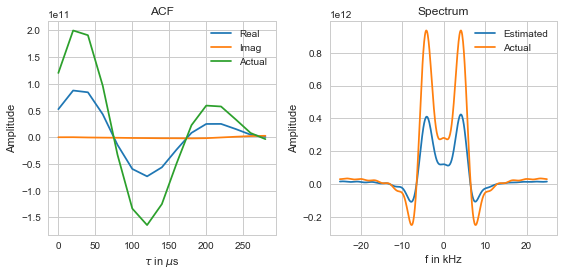

In [44]:
dt=tau[1]-tau[0]
f1,spec_all=acf2spect(l*dt,lagsDatasum,n=nspec)
acf_single = lagsDatasum[50]
spec_single = spec_all[50]

acf_act=scfft.ifftshift(acf)[:L]*W*nspec*nspec/L
feh,spec_act=acf2spect(l*dt,acf_act,n=nspec)

fig5,ax5 = plt.subplots(1,2,sharey=False, figsize=(8,4),facecolor='w')
rp,imp,act_acf=ax5[0].plot(l*dt*1e6,acf_single.real,l*dt*1e6,acf_single.imag,l*dt*1e6,acf_act.real)
ax5[0].legend([rp,imp,act_acf],['Real','Imag','Actual'])
ax5[0].set_ylabel('Amplitude')
ax5[0].set_title('ACF')
ax5[0].set_xlabel(r'$\tau$ in $\mu$s')

est1,act_spec=ax5[1].plot(f*1e-3,spec_single.real,f*1e-3,spec_act.real)
ax5[1].legend([est1,act_spec],['Estimated','Actual'])
ax5[1].set_ylabel('Amplitude')
ax5[1].set_title('Spectrum')
ax5[1].set_xlabel(r'f in kHz')
fig5.tight_layout()